In [1]:
# Magnetic moment classifier using SVM
# https://arxiv.org/abs/1806.07989

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import itertools
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            classification_report, confusion_matrix, \
                            roc_curve, roc_auc_score
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mlxtend.plotting import plot_decision_regions

from tqdm.notebook import tqdm

In [4]:
normalizer = Normalizer()

df_train = pd.read_csv('../datasets/datatrain.csv')
df_test = pd.read_csv('../datasets/datatest.csv')

X_train = df_train.drop(['a', 'b', 'x', 'class'], axis=1)
X_train_norm = normalizer.fit_transform(X_train)
y_train = df_train['class'].values

X_test = df_test.drop(['a', 'b', 'x', 'class'], axis=1)
X_test_norm = normalizer.fit_transform(X_test)
y_test = df_test['class'].values

df_train.head()

,a,b,x,x1,y1,z1,x2,y2,z2,x3,...,m7,m8,m9,m10,mtot,fermi_en,band_en,tot_en,n_el,class
0,Cr2,Ge2,Se6,3.18455,1.83860,11.46022,6.36911,3.67721,11.46366,0.0,...,-0.078,-0.083,-0.068,-0.078,5.740,-3.293012,-453.081400,-47.363580,56.0,1
1,Cr2,Ge2,Te6,3.45884,1.99696,11.73311,6.91770,3.99393,11.73680,0.0,...,-0.094,-0.098,-0.085,-0.094,5.802,-2.261006,-378.802754,-41.769014,56.0,1
2,Cr2,GeP,Se6,3.17526,1.83324,10.94288,6.35053,3.66648,10.94617,-0.0,...,-0.118,-0.076,-0.058,-0.072,5.199,-2.203379,-457.470428,-48.125997,57.0,1
3,Cr2,GeP,Te6,3.43923,1.98564,11.48932,6.87847,3.97128,11.49277,0.0,...,-0.109,-0.088,-0.072,-0.086,5.416,-1.621638,-384.680620,-42.568685,57.0,1
4,Cr2,GeSi,Se6,3.16310,1.82622,11.26573,6.32621,3.65244,11.26911,0.0,...,-0.065,-0.093,-0.074,-0.087,5.741,-3.251253,-448.692635,-48.832091,56.0,1


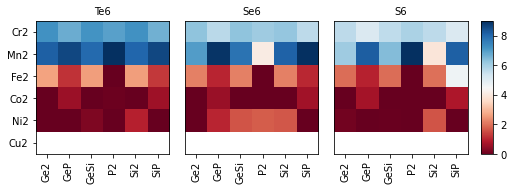

In [25]:
piv_Te = pd.pivot_table(df_train.query('x == "Te6"'), values="mtot", 
                        index=["a"], columns=["b"], fill_value=0)

piv_Se = pd.pivot_table(df_train.query('x == "Se6"'), values="mtot", 
                        index=["a"], columns=["b"], fill_value=0)

piv_S = pd.pivot_table(df_test.query('x == "S6"'), values="mtot", 
                       index=["a"], columns=["b"], fill_value=0)

new_index = [
#              'Ti2', 'V2',
             'Cr2', 'Mn2', 'Fe2', 'Co2',
             'Ni2', 'Cu2',
#              'Y2', 'Nb2', 'Ru2'
            ]

piv_Te = piv_Te.reindex(new_index)
piv_Se = piv_Se.reindex(new_index)
piv_S = piv_S.reindex(new_index)

fig, ax = plt.subplots(1, 3)
im_Te = ax[0].imshow(piv_Te, cmap="RdBu")
im_Se = ax[1].imshow(piv_Se, cmap="RdBu")
im_S = ax[2].imshow(piv_S, cmap="RdBu")

cax = fig.add_axes([ax[2].get_position().x1 + 1.13,
                    ax[2].get_position().y0 - 0.065,
                    0.03,
                    ax[2].get_position().height + 0.123])

fig.colorbar(im_S, ax=ax[2], cax=cax)

ax[0].set_title('Te6', fontsize=10)
ax[0].set_xticks(range(len(piv_Te.columns)))
ax[0].set_yticks(range(len(piv_Te.index)))
ax[0].set_xticklabels(piv_Te.columns, rotation=90)
ax[0].set_yticklabels(piv_Te.index)

ax[1].set_title('Se6', fontsize=10)
ax[1].set_xticks(range(len(piv_Se.columns)))
ax[1].set_yticks([])
ax[1].set_xticklabels(piv_Se.columns, rotation=90)

ax[2].set_title('S6', fontsize=10)
ax[2].set_xticks(range(len(piv_S.columns)))
ax[2].set_yticks([])
ax[2].set_xticklabels(piv_S.columns, rotation=90)

plt.tight_layout()
plt.subplots_adjust(left=1, right=2)
plt.show()

In [6]:
kernel = ['linear', 'rbf', 'poly', 'sigmoid']
C = [0.1, 1, 10, 100, 1000]
gamma = [0.1, 0.01, 0.001, 0.0001, 0.00001]
degree = [1, 2, 3, 4, 5]
n_folds = 5

param_grid = {
    'kernel': kernel,
    'C': C,
    'gamma': gamma,
    'degree': degree
}

pipe = [('pca', PCA()), ('classifier', SVC())]
param_grid_pca = {
    'pca__n_components': [2],
    'classifier__kernel': kernel,
    'classifier__C': C,
    'classifier__gamma': gamma,
    'classifier__degree': degree
}

pipeline = Pipeline(pipe)

In [7]:
grid1 = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=KFold(n_splits=n_folds), 
                     refit=True)
grid1.fit(X_train_norm, y_train)

y_pred1 = grid1.predict(X_test_norm)

print('Best score: {}'.format(grid1.best_score_))
print('Best params: {}'.format(grid1.best_params_))

print('SVM accuracy with best params: {}'.format(accuracy_score(y_pred1, y_test)))
print('Actual test label:    {}'.format(y_test))
print('Predicted test label: {}\n'.format(y_pred1))

print(confusion_matrix(y_test, y_pred1), '\n')

print('Precision: {}'.format(precision_score(y_test, y_pred1)))
print('Recall: {}'.format(recall_score(y_test, y_pred1)))
print('F Score: {}'.format(f1_score(y_test, y_pred1)))

Best score: 0.9833333333333332
Best params: {'C': 1000, 'degree': 1, 'gamma': 0.1, 'kernel': 'linear'}
SVM accuracy with best params: 0.9333333333333333
Actual test label:    [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted test label: [1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]

[[15  2]
 [ 0 13]] 

Precision: 0.8666666666666667
Recall: 1.0
F Score: 0.9285714285714286


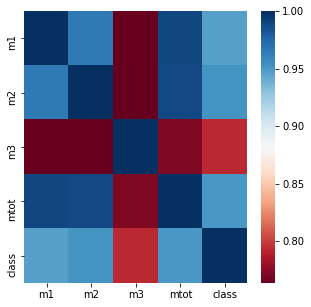

In [11]:
# selected = ['m1', 'm2', 'm3', 'mtot', 'n_el', 'tot_en', 'z3', 'z5', 'z6', 'z7']
# selected = ['m1', 'm2', 'm3', 'mtot', 'z3', 'z5', 'z6', 'z7']
selected = ['m1', 'm2', 'm3', 'mtot']

plt.figure(figsize=(5, 5))
df_corr = pd.concat([pd.DataFrame(X_train, columns=selected), df_train['class']], axis=1)
sns.heatmap(df_corr.corr(), annot=False, cmap='RdBu')

In [12]:
X_train2 = df_train[selected]
X_train2_norm = normalizer.fit_transform(X_train2)

X_test2 = df_test[selected]
X_test2_norm = normalizer.fit_transform(X_test2)

In [13]:
grid2 = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=KFold(n_splits=n_folds), 
                     refit=True)
grid2.fit(X_train2_norm, y_train)

y_pred2 = grid2.predict(X_test2_norm)

print('Best score: {}'.format(grid2.best_score_))
print('Best params: {}'.format(grid2.best_params_))

print('SVM Accuracy with best params: {}'.format(accuracy_score(y_pred2, y_test)))
print('Actual test label:    {}'.format(y_test))
print('Predicted test label: {}\n'.format(y_pred2))

print(confusion_matrix(y_test, y_pred2), '\n')

print('Precision: {}'.format(precision_score(y_test, y_pred2)))
print('Recall: {}'.format(recall_score(y_test, y_pred2)))
print('F Score: {}'.format(f1_score(y_test, y_pred2)))

Best score: 0.85
Best params: {'C': 1000, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
SVM Accuracy with best params: 0.8333333333333334
Actual test label:    [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted test label: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]

[[13  4]
 [ 1 12]] 

Precision: 0.75
Recall: 0.9230769230769231
F Score: 0.8275862068965517


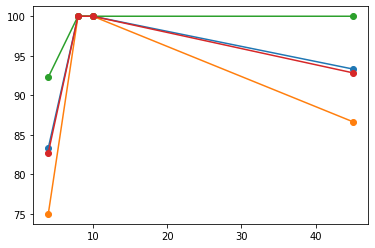

In [27]:
akurasi = [83.34, 100, 100, 93.33]
precision = [75, 100, 100, 86.67]
recall = [92.30, 100, 100, 100]
f1 = [82.75, 100, 100, 92.85]
fitur = [4, 8, 10, 45]

plt.plot(fitur, akurasi, '-o')
plt.plot(fitur, precision, '-o')
plt.plot(fitur, recall, '-o')
plt.plot(fitur, f1, '-o')
plt.show()

In [258]:
pca = PCA(n_components=2)
pca2 = PCA(n_components=2)

# PCA with all features
X_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.transform(X_test)
columns = ['Principal Component 1', 'Principal Component 2']

df_pca = pd.DataFrame(data=X_transformed, columns=columns)
df_pca = pd.concat([df_pca['Principal Component 1'], df_pca['Principal Component 2'], df_train['class']], axis = 1)

# PCA with selected features
X_transformed2 = pca2.fit_transform(X_train2)
X_test_transformed2 = pca2.transform(X_test2)
columns = ['Principal Component 1', 'Principal Component 2']

df_pca2 = pd.DataFrame(data=X_transformed2, columns=columns)
df_pca2 = pd.concat([df_pca2['Principal Component 1'], df_pca2['Principal Component 2'], df_train['class']], axis=1)

# Variance ratio
print('PCA with all features variance ratio:      {}'.format(pca.explained_variance_ratio_))
print('PCA with selected features variance ratio: {}'.format(pca2.explained_variance_ratio_))

PCA with all features variance ratio:      [0.97770989 0.01518983]
PCA with selected features variance ratio: [0.81097431 0.1436613 ]


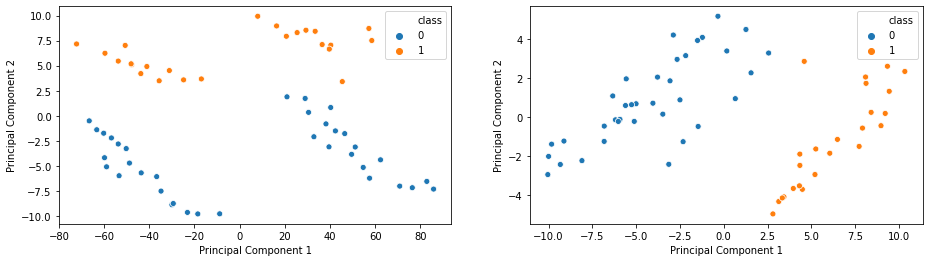

In [259]:
fig, ax = plt.subplots(1, 2)
sns.scatterplot(data=df_pca, x='Principal Component 1', y='Principal Component 2', hue='class', ax=ax[0])
sns.scatterplot(data=df_pca2, x='Principal Component 1', y='Principal Component 2', hue='class', ax=ax[1])
plt.subplots_adjust(left=2, right=4)
fig.show()

In [ ]:
grid3 = GridSearchCV(pipeline, param_grid=param_grid_pca, cv=10)
grid3.fit(X_transformed, y_train)

print('Best score: {}'.format(grid3.score(X_test_transformed, y_test)))
print('Best params: {}'.format(grid3.best_params_))

y_pred3 = grid3.predict(X_test_transformed)

print('SVM Accuracy with best params: {}'.format(accuracy_score(y_pred3, y_test)))
print('Actual test label:    {}'.format(y_test))
print('Predicted test label: {}\n'.format(y_pred3))

print(confusion_matrix(y_test, y_pred3), '\n')

print('Precision: {}'.format(precision_score(y_test, y_pred3)))
print('Recall: {}'.format(recall_score(y_test, y_pred3)))
print('F Score: {}'.format(f1_score(y_test, y_pred3)))

ax = plot_decision_regions(X_transformed, y_train, 
                      clf=grid3, legend=2, 
                      X_highlight=X_test_transformed, zoom_factor=0.1)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['Weak magnet', 'Strong magnet', 'Test data'], 
           framealpha=0.3, scatterpoints=1)

plt.show()

In [ ]:
grid4 = GridSearchCV(pipeline, param_grid=param_grid_pca, cv=10)
grid4.fit(X_transformed2, y_train)

print('Best score: {}'.format(grid4.score(X_test_transformed2, y_test)))
print('Best params: {}'.format(grid4.best_params_))

y_pred4 = grid4.predict(X_test_transformed2)

print('SVM Accuracy with best params: {}'.format(accuracy_score(y_pred4, y_test)))
print('Actual test label:    {}'.format(y_test))
print('Predicted test label: {}\n'.format(y_pred4))

print(confusion_matrix(y_test, y_pred4), '\n')

print('Precision: {}'.format(precision_score(y_test, y_pred4)))
print('Recall: {}'.format(recall_score(y_test, y_pred4)))
print('F Score: {}'.format(f1_score(y_test, y_pred4)))

ax = plot_decision_regions(X_transformed2, y_train, 
                      clf=grid4, legend=2, 
                      X_highlight=X_test_transformed2, zoom_factor=0.2)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          ['Weak magnet', 'Strong magnet', 'Test data'], 
           framealpha=0.3, scatterpoints=1)

plt.show()